## Winoground BLIP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Dependencies

In [2]:
!pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
!pip install datasets
!git clone https://github.com/salesforce/BLIP
%cd BLIP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.4 MB 6.8 MB/s 
     |████████████████████████████████| 376 kB 64.1 MB/s 
     |████████████████████████████████| 235 kB 66.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 49.8 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 3.3 MB 48.3 MB/s 
     |████████████████████████████████| 880 kB 70.5 MB/s 
  Created wheel for fairscale: filename=fairscale-0.4.4-py3-none-any.whl size=292864 sha256=9c51de73d46dff58288c73a1ee58adac3eafc11b76318f4655f275620edabf00
  Stored in directory: /root/.cache/pip/wheels/7e/01/9d/ea7ac6a01eb4044323d028f92fe2ac26c36157ad01b2b907c1
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-

# Load Winoground (enter a huggingface user token or it will fail)

Easily get a token by logging into https://huggingface.co/, clicking on your user profile -> settings -> access tokens -> new token

In [3]:
def get_token(path):
    with open(path + "token.txt") as f:
        return f.read()

In [4]:
from datasets import load_dataset
# Replace with an auth token, which you can get from your huggingface account: Profile -> Settings -> Access Tokens -> New Token
path = "/content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/"
auth_token = get_token(path)
winoground = load_dataset("facebook/winoground", use_auth_token=auth_token)["test"]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset winoground downloaded and prepared to /root/.cache/huggingface/datasets/facebook___winoground/default/0.0.0/ce486f3e39fab90997d6f3c58c4b0103eb9c37011049ef775a465f0ab2e78d7d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

# Load BLIP

In [5]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from models.blip_itm import blip_itm
from tqdm import tqdm
import pandas as pd


def load_image(image, image_size, device):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(image).unsqueeze(0).to(device)
    return image


def load_model(model_url, image_size, device, vit='base'):
    model = blip_itm(pretrained=model_url, image_size=image_size, vit=vit)
    model.eval()
    model = model.to(device)
    return model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 384
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth'
blip_model = load_model(model_url, image_size, device, vit='large')

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_retrieval_coco.pth


# Look at an example from Winoground and get the image-caption scores from BLIP

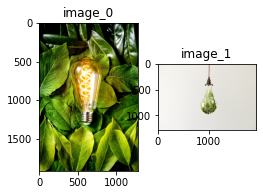

caption_0: some plants surrounding a lightbulb
caption_1: a lightbulb surrounding some plants


In [8]:
from matplotlib import pyplot as plt

def show_example(id):
    ax1 = plt.subplot(1, 3, 1)
    ax1.title.set_text('image_0')
    plt.imshow(winoground[id]["image_0"].convert("RGB"))

    ax2 = plt.subplot(1, 3, 2)
    ax2.title.set_text('image_1')
    plt.imshow(winoground[id]["image_1"].convert("RGB"))

    plt.show()

    print("caption_0:", winoground[id]["caption_0"])
    print("caption_1:", winoground[id]["caption_1"])

show_example(id=155)

In [9]:
def get_blip_scores(id):
    # Note that some images in winoground are RGBA and some are RGB. Need to convert all to RGB with .convert('RGB')
    caption_0 = winoground[id]["caption_0"]
    caption_1 = winoground[id]["caption_1"]
    image_0 = load_image(winoground[id]["image_0"].convert("RGB"), image_size, device)
    image_1 = load_image(winoground[id]["image_1"].convert("RGB"), image_size, device)
    
    output_c0_i0 = blip_model(caption=caption_0, image=image_0, match_head='itm')
    output_c1_i0 = blip_model(caption=caption_1, image=image_0, match_head='itm')
    output_c0_i1 = blip_model(caption=caption_0, image=image_1, match_head='itm')
    output_c1_i1 = blip_model(caption=caption_1, image=image_1, match_head='itm')

    blip_itm_scores_c0_i0 = torch.nn.functional.softmax(output_c0_i0, dim=1)[:, 1].item()
    blip_itm_scores_c1_i0 = torch.nn.functional.softmax(output_c1_i0, dim=1)[:, 1].item()
    blip_itm_scores_c0_i1 = torch.nn.functional.softmax(output_c0_i1, dim=1)[:, 1].item()
    blip_itm_scores_c1_i1 = torch.nn.functional.softmax(output_c1_i1, dim=1)[:, 1].item()

    blip_itc_scores_c0_i0 = blip_model(caption=caption_0, image=image_0, match_head='itc').item()
    blip_itc_scores_c1_i0 = blip_model(caption=caption_1, image=image_0, match_head='itc').item()
    blip_itc_scores_c0_i1 = blip_model(caption=caption_0, image=image_1, match_head='itc').item()
    blip_itc_scores_c1_i1 = blip_model(caption=caption_1, image=image_1, match_head='itc').item()

    blip_itc_scores = {"id": id, "c0_i0": blip_itc_scores_c0_i0, 
                                 "c0_i1": blip_itc_scores_c0_i1, "c1_i0": blip_itc_scores_c1_i0, 
                                 "c1_i1": blip_itc_scores_c1_i1}

    blip_itm_scores = {"id": id, "c0_i0": blip_itm_scores_c0_i0, "c0_i1": blip_itm_scores_c0_i1, 
                         "c1_i0": blip_itm_scores_c1_i0, "c1_i1": blip_itm_scores_c1_i1}

    return blip_itc_scores, blip_itm_scores

blip_itc_scores, blip_itm_scores = get_blip_scores(id=155)

In [10]:
def print_scores(scores):
    print("image_0, caption_0:", scores["c0_i0"])
    print("image_0, caption_1:", scores["c1_i0"])
    print("image_1, caption_0:", scores["c0_i1"])
    print("image_1, caption_1:", scores["c1_i1"])

print("BLIP itc image-text match scores:")
print_scores(blip_itc_scores)

print()
print("BLIP itm image-text match scores:")
print_scores(blip_itm_scores)

BLIP itc image-text match scores:
image_0, caption_0: 0.5049379467964172
image_0, caption_1: 0.5085135698318481
image_1, caption_0: 0.4590267539024353
image_1, caption_1: 0.44550853967666626

BLIP itm image-text match scores:
image_0, caption_0: 0.9965253472328186
image_0, caption_1: 0.9956040382385254
image_1, caption_0: 0.9410456418991089
image_1, caption_1: 0.9158617854118347


# Get BLIP image-caption scores from the whole dataset

In [11]:
from tqdm import tqdm

def get_all_blip_scores():  
    winoground_blip_itc_scores = [] 
    winoground_blip_itm_scores = []
    for id in tqdm(range(len(winoground))):
        blip_itc_scores, blip_itm_scores = get_blip_scores(id=id)
        winoground_blip_itc_scores.append(blip_itc_scores)
        winoground_blip_itm_scores.append(blip_itm_scores)

    return winoground_blip_itc_scores, winoground_blip_itm_scores

winoground_blip_itc_scores, winoground_blip_itm_scores = get_all_blip_scores()

100%|██████████| 400/400 [09:47<00:00,  1.47s/it]


In [12]:
def save_results(filename, winoground_scores):
    with open(filename, 'w') as f:
        for scores in winoground_scores:
            f.write(f'{{"label": "{scores["id"]}_c0_i0", "score": {scores["c0_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i0", "score": {scores["c1_i0"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c0_i1", "score": {scores["c0_i1"]}}}\n')
            f.write(f'{{"label": "{scores["id"]}_c1_i1", "score": {scores["c1_i1"]}}}\n')

path = "/content/drive/MyDrive/PhD/2022 Julen Etxaniz EHU/MAL/winoground/"
save_results(path + "results/blip_itm_l16_coco.jsonl", winoground_blip_itm_scores)
save_results(path + "results/blip_itc_l16_coco.jsonl", winoground_blip_itc_scores)

# Define the text, image, and group metrics, and compute the overall performance of BLIP

In [13]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

def print_performance(winoground_scores):
    text_correct_count = 0
    image_correct_count = 0
    group_correct_count = 0
    for result in winoground_scores:
        text_correct_count += 1 if text_correct(result) else 0
        image_correct_count += 1 if image_correct(result) else 0
        group_correct_count += 1 if group_correct(result) else 0

    denominator = len(winoground_scores)
    print("text score:", text_correct_count/denominator)
    print("image score:", image_correct_count/denominator)
    print("group score:", group_correct_count/denominator)

print("BLIP itc scores:")
print_performance(winoground_blip_itc_scores)

print()
print("BLIP itm scores:")
print_performance(winoground_blip_itm_scores)

BLIP itc scores:
text score: 0.3775
image score: 0.1375
group score: 0.105

BLIP itm scores:
text score: 0.4675
image score: 0.24
group score: 0.205
